# Importing Libraries

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import matplotlib.ticker as tick

%matplotlib inline
sns.set_style('whitegrid')

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
import os
import errno
import sys
from tqdm.notebook import tqdm

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder

In [10]:
import keras

from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications import inception_v3
from keras.layers import GlobalAveragePooling2D, MaxPooling2D, AveragePooling2D, Dense, Dropout, Flatten, Conv2D, BatchNormalization, Activation
from keras.models import Sequential

In [11]:
import datetime
now = datetime.datetime.now

In [12]:
from PIL import Image
from keras.preprocessing import image
import cv2
import imageio.v2 as imageio

# Importing Mood Detection Dataset

In [13]:
def createDF(directory):
    imagepath = []
    labels = []
    for label in os.listdir(directory):
        for names in os.listdir(os.path.join(directory, label)):
            imagepath.append(os.path.join(directory, label, names))
            labels.append(label)
        print(label, 'completed')
    return imagepath, labels

> <p align = 'justify'> This function will let me create a dataset by passing the directory and it will traverse available sub-directories. In order to retrieve the individual images, we'll traverse on every sub-directories and append every image into the imagepath array and append the label to the labels list. Hence, it will print a complete statement for every label complete and will return a separate list of imagepath and label.

## Mood Detection Training Dataset 

In [14]:
train_df = pd.DataFrame()

train_df['image'], train_df['label'] = createDF(R'D:/vrsp11603/Schoolworks/DS3/Mood Detection/Dataset3/Train')

train_df.head()

Angry completed
Confused completed
Happy completed
Sad completed


,image,label
0,D:/vrsp11603/Schoolworks/DS3/Mood Detection/Da...,Angry
1,D:/vrsp11603/Schoolworks/DS3/Mood Detection/Da...,Angry
2,D:/vrsp11603/Schoolworks/DS3/Mood Detection/Da...,Angry
3,D:/vrsp11603/Schoolworks/DS3/Mood Detection/Da...,Angry
4,D:/vrsp11603/Schoolworks/DS3/Mood Detection/Da...,Angry


In [15]:
train_df.shape

train_df.info()

train_df.label.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   800 non-null    object
 1   label   800 non-null    object
dtypes: object(2)
memory usage: 12.6+ KB


label
Angry       200
Confused    200
Happy       200
Sad         200
Name: count, dtype: int64

## Mood Detection Validation Dataset

In [16]:
valid_df = pd.DataFrame()

valid_df['image'], valid_df['label'] = createDF('D:/vrsp11603/Schoolworks/DS3/Mood Detection/Dataset3/Valid')

valid_df.head()

Angry completed
Confused completed
Happy completed
Sad completed


,image,label
0,D:/vrsp11603/Schoolworks/DS3/Mood Detection/Da...,Angry
1,D:/vrsp11603/Schoolworks/DS3/Mood Detection/Da...,Angry
2,D:/vrsp11603/Schoolworks/DS3/Mood Detection/Da...,Angry
3,D:/vrsp11603/Schoolworks/DS3/Mood Detection/Da...,Angry
4,D:/vrsp11603/Schoolworks/DS3/Mood Detection/Da...,Angry


In [17]:
valid_df.shape

valid_df.info()

valid_df.label.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   200 non-null    object
 1   label   200 non-null    object
dtypes: object(2)
memory usage: 3.3+ KB


label
Angry       50
Confused    50
Happy       50
Sad         50
Name: count, dtype: int64

> <p align = 'justify'> I created a two separate directories for training and validation data where here, I passed the directory for the training data and validation data. The data doesn't show any missing values and also the value counts of the each label. The training has 200 entries per label while validation has 50 each. Therefore, we will not worry on the imbalance of the data.

# Feature Extraction

In [18]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale = True , target_size = (224, 224))
        img_arr = np.array(img)
        features.append(img_arr)
    features_arr = np.array(features)
    features = features_arr.reshape(len(features), 224, 224, 1)
    return features

> <p align = 'justify'> This function, extract_features, allows the dataset to be preprocessed such as loading the image into a conversion such as grayscale for removing the noise in rgb and resizing it to be uniform for training. It also include conversion of image into array values for preprocessing which are appended into the features list. Then, the features_arr is reshapes the features into a 4 dimensional shape where it has the total number of entries, width, height, and channel.

In [19]:
# Passing the features of train dataframe and valid dataframe into x_train and x_valid
x_train = extract_features(train_df['image'])
x_valid = extract_features(valid_df['image'])

# Normalization of image data
x_train = x_train/255.0
x_valid = x_valid/255.0

print(x_train.shape)
print(x_valid.shape)

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

(800, 224, 224, 1)
(200, 224, 224, 1)


> <p align = 'justify'> In this part, we proceed to retrieve the values of the image and store it into x_train and x_valid. We also normalize the image data by dividing it with 255 in order for the pixel values to fall into 0 to 1 range

In [20]:
le = LabelEncoder()

# Assignment of numerical values to label values
y_train = le.fit_transform(train_df.label)
y_valid = le.transform(valid_df.label)

print('Data Label Unique Values: ', train_df.label.unique())

print('y_train Shape: ', y_train.shape, '\n', y_train)
print('y_valid Shape: ', y_valid.shape, '\n', y_valid)

Data Label Unique Values:  ['Angry' 'Confused' 'Happy' 'Sad']
y_train Shape:  (800,) 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 

> <p align = 'justify'> Given that the label column is a object, it is necessary to assign a numerical value for them. Hence, we label encoded them just as presented.

In [21]:
y_train_cat = keras.utils.to_categorical(y_train, num_classes = 4)
y_valid_cat = keras.utils.to_categorical(y_valid, num_classes = 4)

print('y_train categorical:\n', y_train_cat)
print('y_train categorical:\n', y_valid_cat)

y_train categorical:
 [[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]
y_train categorical:
 [[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 

> <p align = 'justify'> The transformation of y_train and y_valid into categorical is a necessary step because the output shape will mismatch the shape for these y values.||

# Neural Network Training

In [22]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,reduce_learningrate]

In [23]:
mood_model1 = Sequential()

mood_model1.add(Conv2D(32, (3, 3), (2, 2), padding='same', activation = 'relu', input_shape = x_train.shape[1:]))
mood_model1.add(Conv2D(32, (3, 3), (2, 2), padding='same', activation = 'relu'))
mood_model1.add(MaxPooling2D(2, 2))
mood_model1.add(Dropout(0.5))

mood_model1.add(Conv2D(64, (3, 3), (2, 2), padding='same', activation = 'relu'))
mood_model1.add(Conv2D(64, (3, 3), (2, 2), padding='same', activation = 'relu'))
mood_model1.add(MaxPooling2D(2, 2))
mood_model1.add(Dropout(0.5))

mood_model1.add(Flatten())
mood_model1.add(Dense(512, activation = 'relu'))
mood_model1.add(Dropout(0.5))
mood_model1.add(Dense(4, activation = 'sigmoid'))

mood_model1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 28, 28, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 28, 28, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 64)          36928     
                                                       

In [24]:
mood_model1.compile(
    optimizer = keras.optimizers.Adam(learning_rate = 0.0003),
    loss = 'categorical_crossentropy',
    metrics = ['mae', 'accuracy']
)

mood_hist_1 = mood_model1.fit(
    x = x_train, 
    y = y_train_cat,
    validation_data = (x_valid, y_valid_cat),
    epochs = 50,
    callbacks = callbacks_list
)

Epoch 1/50




25/25 [==============================] - 4s 106ms/step - loss: 1.3879 - mae: 0.5003 - accuracy: 0.2537 - val_loss: 1.3833 - val_mae: 0.4997 - val_accuracy: 0.2500 - lr: 3.0000e-04
Epoch 2/50
25/25 [==============================] - 3s 112ms/step - loss: 1.3785 - mae: 0.4999 - accuracy: 0.2750 - val_loss: 1.3737 - val_mae: 0.5001 - val_accuracy: 0.3450 - lr: 3.0000e-04
Epoch 3/50
25/25 [==============================] - 3s 112ms/step - loss: 1.3641 - mae: 0.5016 - accuracy: 0.3300 - val_loss: 1.3364 - val_mae: 0.5000 - val_accuracy: 0.4650 - lr: 3.0000e-04
Epoch 4/50
25/25 [==============================] - 3s 108ms/step - loss: 1.2736 - mae: 0.4962 - accuracy: 0.4263 - val_loss: 1.1613 - val_mae: 0.4837 - val_accuracy: 0.4900 - lr: 3.0000e-04
Epoch 5/50
25/25 [==============================] - 3s 109ms/step - loss: 1.0193 - mae: 0.4531 - accuracy: 0.5475 - val_loss: 0.9841 - val_mae: 0.4428 - val_accuracy: 0.5850 - lr: 3.0000e-04
Epoch 6/50
25/25 [==============================] - 2s

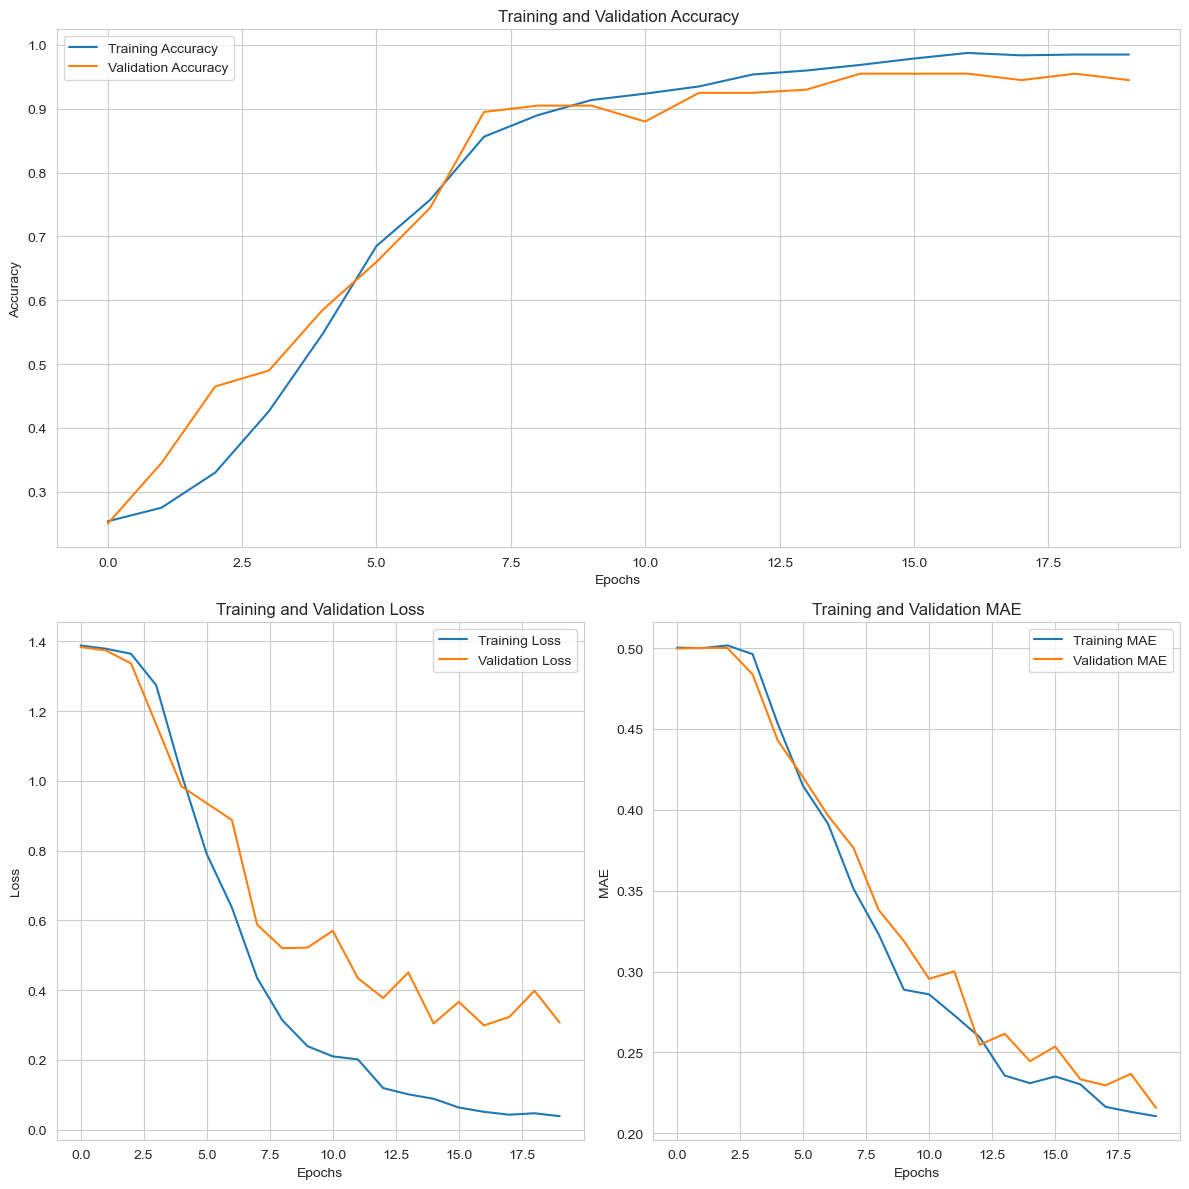

In [25]:
plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
plt.plot(mood_hist_1.history['accuracy'], label='Training Accuracy')
plt.plot(mood_hist_1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(mood_hist_1.history['loss'], label='Training Loss')
plt.plot(mood_hist_1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(mood_hist_1.history['mae'], label='Training MAE')
plt.plot(mood_hist_1.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
score_1 = mood_model1.evaluate(x_valid, y_valid_cat, verbose=1)

print('Training Loss: ', score_1[0])
print('Training MAE: ', score_1[1])
print('Training Accuracy: ', score_1[2])

7/7 [==============================] - 0s 17ms/step - loss: 0.2991 - mae: 0.2334 - accuracy: 0.9550
Training Loss:  0.29906967282295227
Training MAE:  0.23336701095104218
Training Accuracy:  0.9549999833106995


> <p align = 'justify'> For the figure, the model achieved great numbers given that the MAE is around 0.2, the loss also shows good rate of learning with 0.3, and a high training accuracy of 95%

In [27]:
y_pred_prob = mood_model1.predict(x_valid, batch_size = 32, verbose = 1)

print('y_pred_prob[0]: ', y_pred_prob[0])
print('y_valid_cat[0]: ', y_valid_cat[0])

7/7 [==============================] - 0s 16ms/step


y_pred_prob[0]:  [0.9994453  0.9285502  0.10602438 0.00937499]
y_valid_cat[0]:  [1. 0. 0. 0.]


> <p align = 'justify'> In this part, we can observe the values for prediction with y_pred_prob displaying the probabilities of the model detecting the moods while the y_valid_cat corresponds with the highest probability.

In [28]:
y_test_class = np.argmax(y_valid_cat, axis=1)
y_pred_class = np.argmax(mood_model1.predict(x_valid), axis=1).astype('int64')

print('y_pred_class[0]: ', y_pred_class[0])
print('y_test_class[0]: ', y_test_class[0])

7/7 [==============================] - 0s 17ms/step
y_pred_class[0]:  0
y_test_class[0]:  0


## Classification Report

In [29]:
def get_conf(y_tes, y_pred, label_name, title='Confusion Matrix'):
    conf_m = confusion_matrix(y_tes, y_pred)
    labels = label_name
    plt.figure(figsize = (6, 6))
    sns.set(font_scale = 1.2)
    sns.heatmap(conf_m, annot = True, fmt = 'd', cmap = 'Pastel1', linewidths = .5, cbar = False,
    square = True, xticklabels = labels, yticklabels = labels)

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    return conf_m

In [30]:
print(classification_report(y_test_class, y_pred_class, target_names = train_df.label.unique()))

              precision    recall  f1-score   support

       Angry       1.00      1.00      1.00        50
    Confused       0.85      1.00      0.92        50
       Happy       1.00      1.00      1.00        50
         Sad       1.00      0.82      0.90        50

    accuracy                           0.95       200
   macro avg       0.96      0.95      0.95       200
weighted avg       0.96      0.95      0.95       200



In [31]:
print(multilabel_confusion_matrix(y_test_class, y_pred_class))

[[[150   0]
  [  0  50]]

 [[141   9]
  [  0  50]]

 [[150   0]
  [  0  50]]

 [[150   0]
  [  9  41]]]


> <p align = 'justify'>

accuracy_score:  0.955


array([[50,  0,  0,  0],
       [ 0, 50,  0,  0],
       [ 0,  0, 50,  0],
       [ 0,  9,  0, 41]], dtype=int64)

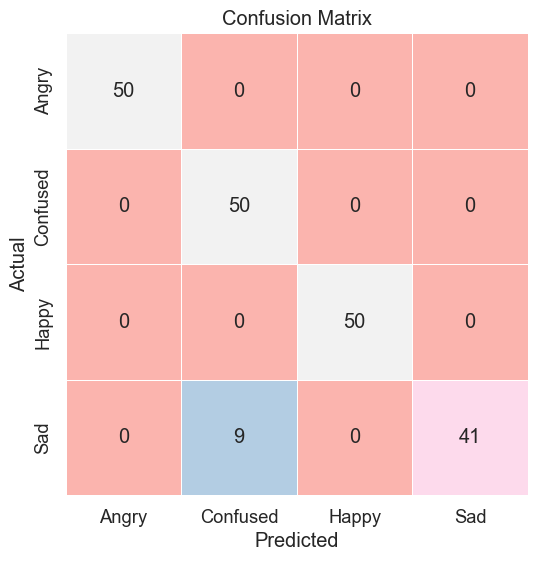

In [32]:
print('accuracy_score: ', accuracy_score(y_test_class, y_pred_class))
get_conf(y_test_class, y_pred_class, label_name = train_df.label.unique())

> <p align = 'justify'> The model executes well as it managed to predict mostly of the labels with confused and sad being intertwined.

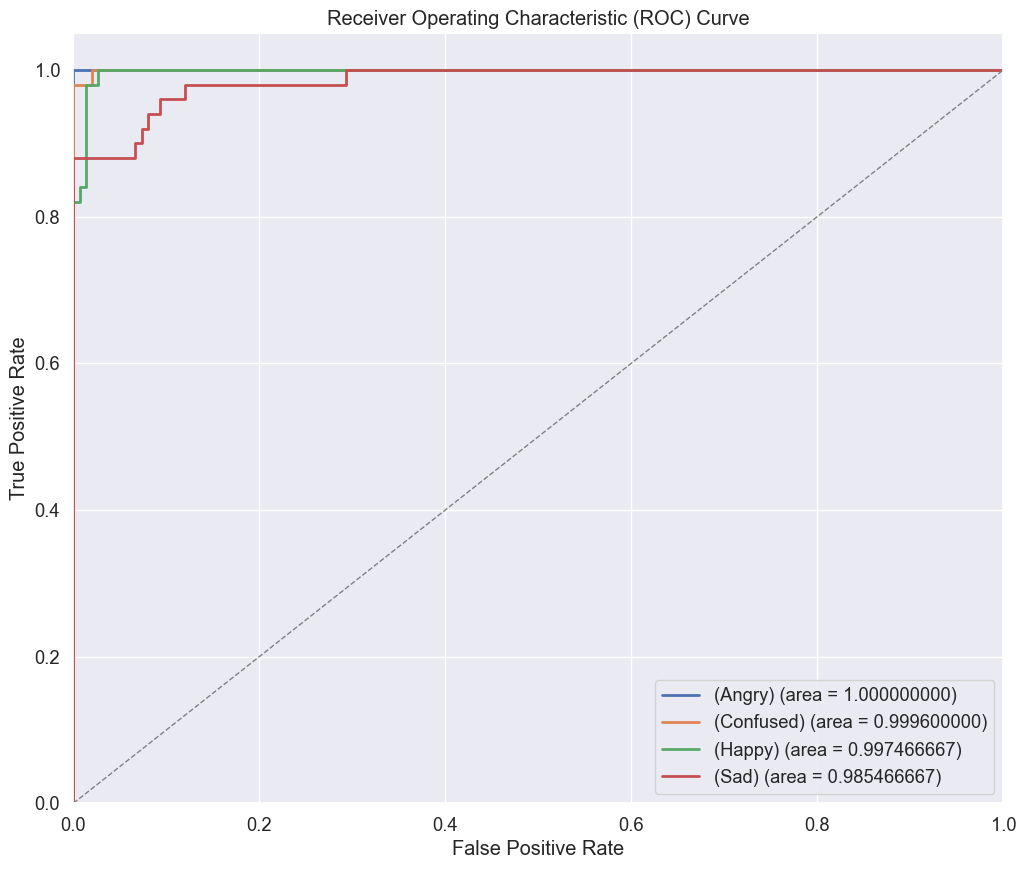

In [33]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(train_df.label.unique())):
    fpr[i], tpr[i], _ = roc_curve(y_valid_cat[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(12, 10))
for i in range(len(train_df.label.unique())):
    plt.plot(fpr[i], tpr[i], lw=2, label='({}) (area = {:.9f})'.format(train_df.label.unique()[i], roc_auc[i]))

# Plot random guessing line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

> <p align = 'justify'> The roc_auc also shows good output as it signifies the reliability of the model on predicting the mood.

# Testing

In [34]:
def get_image(camera):
    retval, im = camera.read()
    return im

# This function takes a camera object as input.

def save_webcam_image(img_path):

    try:
        camera_port = 0
        ramp_frames = 10
    
        camera = cv2.VideoCapture(camera_port)

        for i in range(ramp_frames):
            retval, im_camera = camera.read()

        retval, im_camera = camera.read()

        im = cv2.resize(im_camera, (224, 224)).astype(np.float32)
        cv2.imwrite(img_path, im)
        del (camera)
        return True
    except ValueError as e:
        print("Image Capture Failed")
    return False

# This function saves an image captured from a webcam to a file.

def load_and_preprocess_image(image_path, target_size=(224, 224)):
    img = cv2.imread(image_path)
    if img is None:
        print("Error: Unable to load image.")
        return None

    # Convert image to grayscale and resize
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resized_img = cv2.resize(gray, target_size)
    
    # Reshape image to match model input shape (assuming it's expecting a single image)
    input_img = np.expand_dims(resized_img, axis=0)
    
    return input_img

# handles common preprocessing steps such as converting to grayscale, resizing, and reshaping the image to match the input requirements of the model

def predict_mood(img, model, train_labels = train_df['label']):
    input_img = load_and_preprocess_image(img)

    if input_img is not None:
        predict_prob = model.predict(input_img)
        predictions_class = np.argmax(predict_prob, axis=1).astype('int64')

        # Get the unique labels from train_df.label
        unique_labels = train_labels.unique()

        # Map predictions_class to unique labels
        predicted_class = unique_labels[predictions_class[0]]

        plt.imshow(imageio.imread(img))
        print('Predicted probabilities:', ', '.join([f'{prob:.9f}' for prob in predict_prob[0]]))
        print('Predicted class:', predictions_class)
        print('Predicted class:', predicted_class)
    else:
        print("Error: Image preprocessing failed.")

# Used for presenting the prediction results


## Saved Images

1/1 [==============================] - 0s 107ms/step
Predicted probabilities: 0.000000000, 0.000000000, 1.000000000, 1.000000000
Predicted class: [2]
Predicted class: Happy


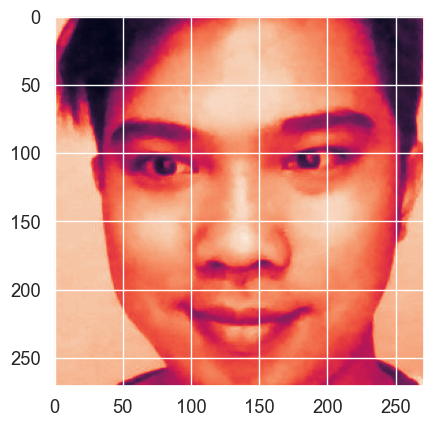

In [35]:
predict_mood(R"D:/vrsp11603/Schoolworks/DS3/Mood Detection/Dataset/Happy/detected_face_11.jpg", mood_model1)

1/1 [==============================] - 0s 25ms/step
Predicted probabilities: 0.000000000, 0.000000000, 1.000000000, 1.000000000
Predicted class: [2]
Predicted class: Happy


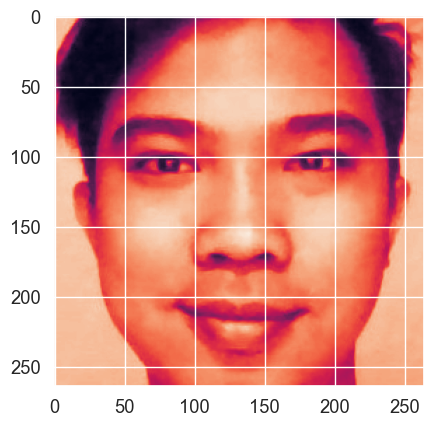

In [36]:
predict_mood(R"D:\vrsp11603\Schoolworks\DS3\Mood Detection\Dataset\Happy\detected_face_63.jpg", mood_model1)

1/1 [==============================] - 0s 29ms/step
Predicted probabilities: 0.000000000, 0.000000000, 1.000000000, 1.000000000
Predicted class: [2]
Predicted class: Happy


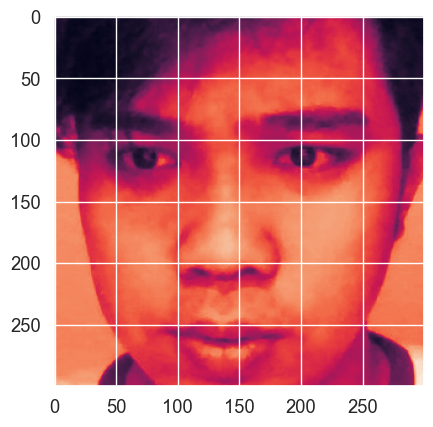

In [37]:
predict_mood(R"D:/vrsp11603/Schoolworks/DS3/Mood Detection/Dataset/Confused/detected_face_99.jpg", mood_model1)

1/1 [==============================] - 0s 25ms/step
Predicted probabilities: 0.000000000, 1.000000000, 1.000000000, 0.000000000
Predicted class: [1]
Predicted class: Confused


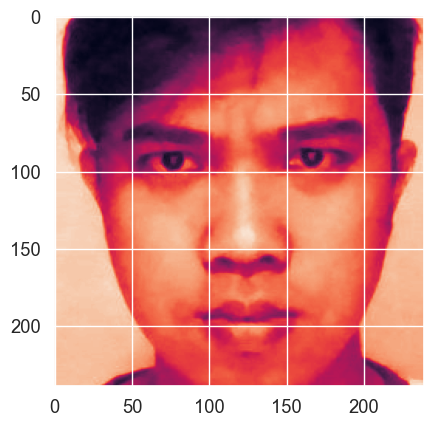

In [38]:
predict_mood(R"D:\vrsp11603\Schoolworks\DS3\Mood Detection\Dataset\Angry\detected_face_99.jpg", mood_model1)

1/1 [==============================] - 0s 25ms/step
Predicted probabilities: 1.000000000, 1.000000000, 0.000000000, 0.000000000
Predicted class: [0]
Predicted class: Angry


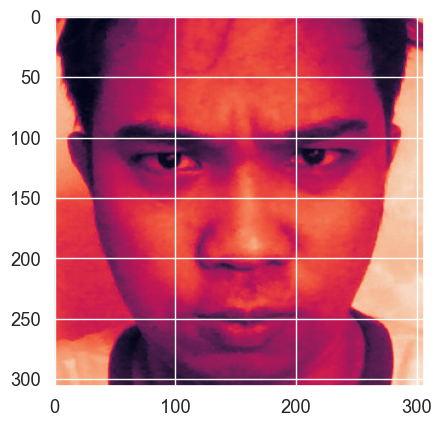

In [39]:
predict_mood(R"D:\vrsp11603\Schoolworks\DS3\Mood Detection\Dataset3\Train\Angry\detected_face_1.jpg", mood_model1)

1/1 [==============================] - 0s 30ms/step
Predicted probabilities: 1.000000000, 0.000000000, 0.000000000, 0.000000000
Predicted class: [0]
Predicted class: Angry


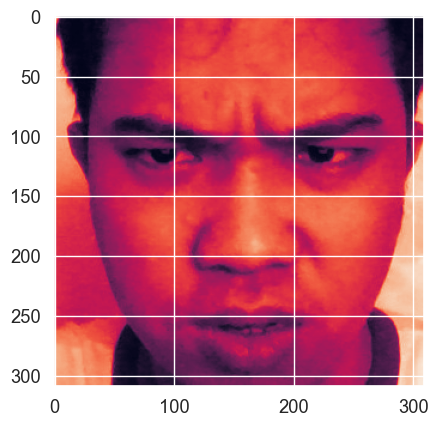

In [40]:
path = R'd:\vrsp11603\Schoolworks\DS3\Mood Detection\Dataset3\Train\Angry\detected_face_125.jpg'

predict_mood(path, mood_model1)

## Webcam Saved Images

1/1 [==============================] - 0s 23ms/step
Predicted probabilities: 0.000000000, 0.000000000, 1.000000000, 1.000000000
Predicted class: [2]
Predicted class: Happy


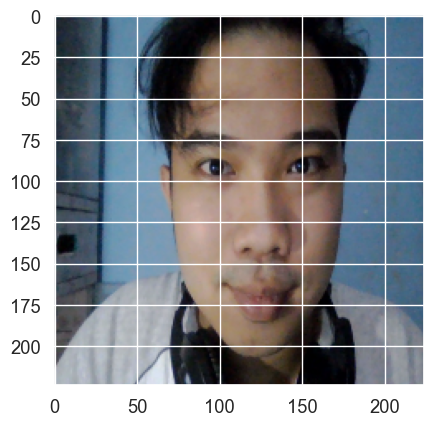

In [55]:
img_path = "test_1.png"

if save_webcam_image(img_path) is False:
    # Webcam not active, use the Dog Image
    img_path = "rocking_chair.jpg"
    print("Using the Test Rocking Chair Image: {}".format(img_path))
    
predict_mood(img_path, mood_model1)

1/1 [==============================] - 0s 23ms/step
Predicted probabilities: 0.000000000, 1.000000000, 0.999998152, 1.000000000
Predicted class: [1]
Predicted class: Confused


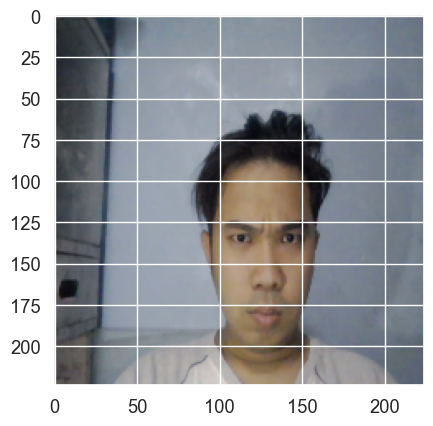

In [59]:
img_path2 = "test_2.png"

if save_webcam_image(img_path2) is False:
    # Webcam not active, use the Dog Image
    img_path2 = "rocking_chair.jpg"
    print("Using the Test Rocking Chair Image: {}".format(img_path2))

# predict_mood(R"D:\vrsp11603\Schoolworks\DS3\Mood Detection\Dataset3\Valid\Confused\detected_face_210.jpg", mood_model1)
predict_mood(img_path2, mood_model1)

# Implementation to Face Recognition

In [ ]:
def read_images(path = R'D:\vrsp11603\Schoolworks\DS3\DS Face recog\cropped', sz=None):
  c = 0
  X, y = [], []

  for dirname, dirnames, filenames in os.walk(path):
    for subdirname in dirnames:
      subject_path = os.path.join(dirname, subdirname)
      for filename in os.listdir(subject_path):
        try:
          if(filename == ".directory"):
            continue
          filepath = os.path.join(subject_path, filename)
          im = cv2.imread(os.path.join(subject_path, filename), cv2.IMREAD_GRAYSCALE)

          if im is None:
            print("Error: Unable to read image:", filepath)
            continue

          # Check the shape of the image
          # print("Image shape before resize:", im.shape)

          # Resize the images to the prescribed size
          if (sz is not None):
            im = cv2.resize(im, (200,200))

          if im is not None:
            X.append(np.asarray(im, dtype=np.uint8))
            y.append(c)


        except IOError as e:
          print(f"I/O Error({e.errno}): {e.strerror}")
        except:
          print("Unexpected error:", sys.exc_info()[0])
          raise
      c = c+1
  return [X, y]

In [ ]:
def return_mood(img, model = mood_model1, train_labels = train_df['label']):
    input_img = load_and_preprocess_image(img)

    if input_img is not None:
        predict_prob = model.predict(input_img)
        predictions_class = np.argmax(predict_prob, axis=1).astype('int64')

        # Get the unique labels from train_df.label
        unique_labels = train_labels.unique()

        # Map predictions_class to unique labels
        predicted_class = unique_labels[predictions_class[0]]

        plt.imshow(imageio.imread(img))

    return predicted_class

In [ ]:
def face_rec(mood_model = mood_model1):
    names = ['Pena']  # Put your names here for faces to recognize

    if len(sys.argv) < 2:
        print("USAGE: facerec_demo.py </path/to/images> [</path/to/store/images/at>]")
        sys.exit()

    folder_path = R'D:/vrsp11603/Schoolworks/DS3/DS Face recog/cropped/'
    X, y = read_images(folder_path, (224, 224))
    y = np.asarray(y, dtype=np.int32)

    if len(X) == 0:
        print("No images found in the specified folder.")
        return

    model = cv2.face.LBPHFaceRecognizer_create()
    model.train(X, y)

    mood = ['Angry', 'Confused', 'Happy', 'Sad']

    camera = cv2.VideoCapture(0)
    face_cascade = cv2.CascadeClassifier(R"D:\vrsp11603\Schoolworks\DS3\Mood Detection\haarcascade_frontalface_default.xml")

    while True:
        ret, img = camera.read()
        if not ret:
            break

        faces = face_cascade.detectMultiScale(img, 1.3, 5)

        # Track the number of detected faces
        num_faces = len(faces)

        # Process only the first detected face, if any
        if num_faces > 0:
            x, y, w, h = faces[0]  # Extract the coordinates of the first detected face
            cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
            gray = cv2.cvtColor(img[y:y + h, x:x + w], cv2.COLOR_BGR2GRAY)
            roi = cv2.resize(gray, (200, 200))

            try:
                params = model.predict(roi)
                label = names[params[0]]
                #cv2.putText(img, label, (x, y - 20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

                mood_pred = mood_model.predict(roi)
                mood_label = np.argmax(mood_pred)
                cv2.putText(img, mood[mood_label], (x, y - 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
            except:
                continue

        # Label other detected faces as "Unknown"
        for i in range(1, num_faces):
            x, y, w, h = faces[i]  # Extract the coordinates of the additional detected faces
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 0, 255), 2)  # Draw a red rectangle around the face
            cv2.putText(img, "Unknown", (x, y - 20), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)  # Label as "Unknown"

        cv2.imshow("camera", img)
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break

    camera.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    face_rec()

NameError: name 'mood_model1' is not defined

# Face Recognition 2

In [ ]:
def load_images_from_folder(folder, target_size=(200, 200)):
    images = []
    labels = []
    label = 0  # Use a single label for all images
    
    if os.path.isdir(folder):
        for filename in os.listdir(folder):
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                # Resize image to target size
                img = cv2.resize(img, target_size)
                images.append(img)
                labels.append(label)

    return images, labels

In [ ]:
known_faces_folder = R'D:\vrsp11603\Schoolworks\DS3\DS Face recog\cropped\Pena'
known_faces, known_labels = load_images_from_folder(known_faces_folder)


# Train recognizer
recognizer = cv2.face.LBPHFaceRecognizer_create()
recognizer.train(known_faces, np.array(known_labels))

# Load face cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [ ]:
def predict_faces(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    for (x, y, w, h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        label, confidence = recognizer.predict(roi_gray)
        # mood = return_mood(roi_gray)
        if confidence < 100: # Adjust threshold as needed
            name = "Unknown"
            if label in known_labels:
                name = 'Vhan'  # Assuming labels are names or IDs
            cv2.putText(image, name, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        else:
            cv2.putText(image, "Unknown", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
        cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)
    
    return image

AbortedError: Graph execution error:

Detected at node sequential/max_pooling2d/MaxPool defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "c:\Users\User\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "c:\Users\User\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "c:\Users\User\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 736, in start

  File "c:\Users\User\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "c:\Users\User\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "c:\Users\User\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "c:\Users\User\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "c:\Users\User\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue

  File "c:\Users\User\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one

  File "c:\Users\User\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell

  File "c:\Users\User\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request

  File "c:\Users\User\anaconda3\Lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute

  File "c:\Users\User\anaconda3\Lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell

  File "c:\Users\User\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell

  File "c:\Users\User\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell

  File "c:\Users\User\anaconda3\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "c:\Users\User\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async

  File "c:\Users\User\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes

  File "c:\Users\User\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code

  File "C:\Users\User\AppData\Local\Temp\ipykernel_11768\2888504521.py", line 8, in <module>

  File "C:\Users\User\AppData\Local\Temp\ipykernel_11768\1153765207.py", line 15, in predict_faces

  File "c:\Users\User\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\User\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2655, in predict

  File "c:\Users\User\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2440, in predict_function

  File "c:\Users\User\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2425, in step_function

  File "c:\Users\User\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2413, in run_step

  File "c:\Users\User\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2381, in predict_step

  File "c:\Users\User\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\User\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 590, in __call__

  File "c:\Users\User\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\User\anaconda3\Lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "c:\Users\User\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "c:\Users\User\anaconda3\Lib\site-packages\keras\src\engine\sequential.py", line 398, in call

  File "c:\Users\User\anaconda3\Lib\site-packages\keras\src\engine\functional.py", line 515, in call

  File "c:\Users\User\anaconda3\Lib\site-packages\keras\src\engine\functional.py", line 672, in _run_internal_graph

  File "c:\Users\User\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\User\anaconda3\Lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "c:\Users\User\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "c:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\pooling\base_pooling2d.py", line 84, in call

Compute received an exception:Status: 2, message: could not create a descriptor for a pooling forward propagation primitive, in file tensorflow/core/kernels/mkl/mkl_maxpooling_op.cc:211
	 [[{{node sequential/max_pooling2d/MaxPool}}]] [Op:__inference_predict_function_7510]

# Conclusion

> <p align = 'justify'> In this activity, I've managed to atleast implement the mood detection into fixed images. Given that the dataset is a custom-made, it contributes a lot to the model as the expressions of confused and angry has commonality such as the frown in the forehead which we can observe on the testing that there are mixed-up on that. I think I've managed to explore a bit on the approaches I can perform such trying to use the flow_from_directory, deepface, and more.